Aim
---
To investigate the map errors induced by altering the power law index of the GSMA.

In [45]:
import src.sky_models as SM
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import healpy as hp
import seaborn as sns

In [46]:
T230 = SM.foreground_gsma_nsidelo(nu=230)
TCMB = SM.T_CMB

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Want to see how relevant the CMB contribution to the following formula is:
$$
\frac{\Delta \mathbf{T}_{230}}{\mathbf{T}_{230}} = \left[\left(\frac{408}{230}\right)^{\boldsymbol{\delta}}-1\right]\left(1 - \frac{T_\mathrm{CMB}}{\mathbf{T}_{230}}\right)
$$

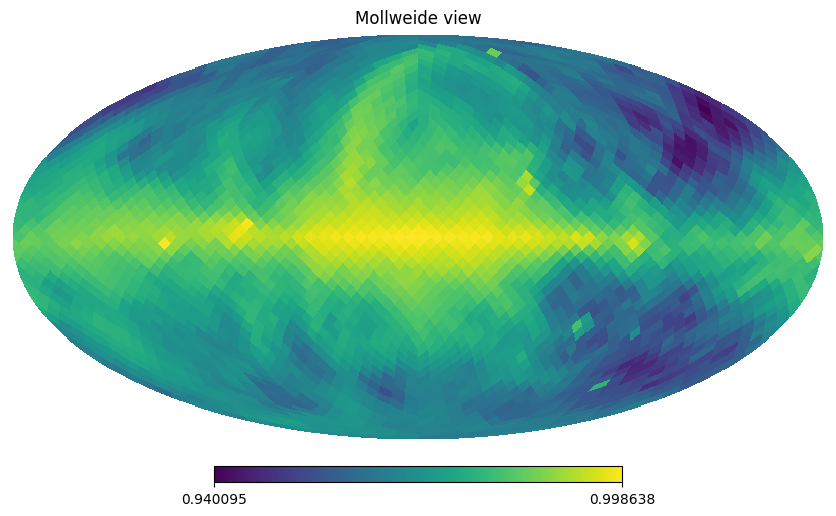

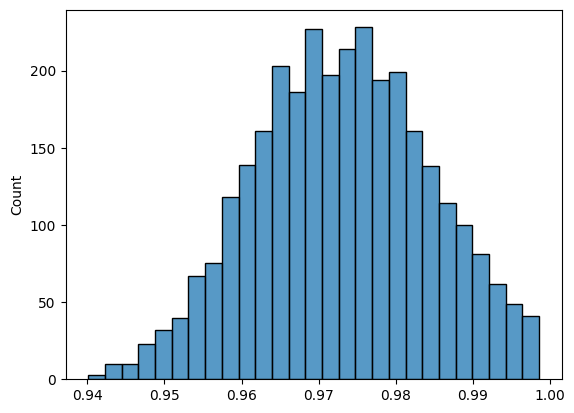

In [47]:
hp.mollview(1-TCMB/T230)
plt.show()
sns.histplot(1-TCMB/T230)
plt.show()

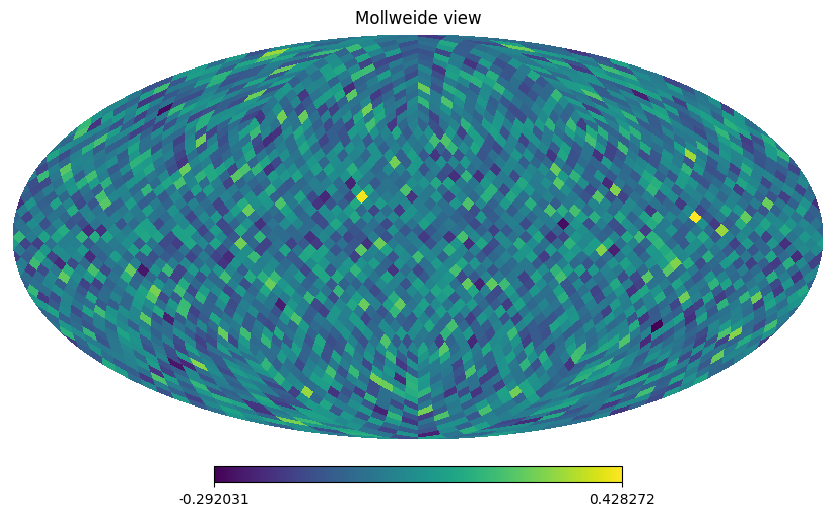

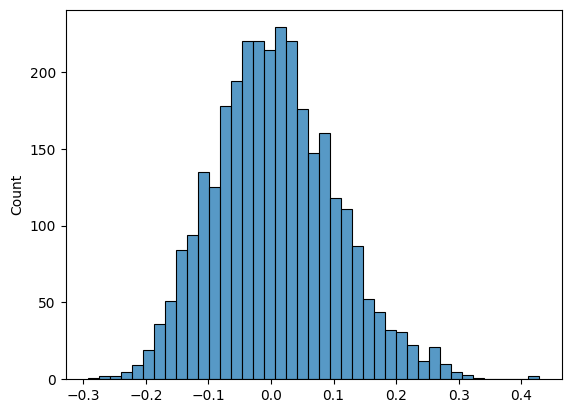

In [58]:
percent_err = 10
delta_vec = np.random.normal(scale=SM.basemap_err_to_delta(percent_err), size=np.shape(T230))
hp.mollview((408/230)**delta_vec - 1)
plt.show()
sns.histplot((408/230)**delta_vec - 1)
plt.show()

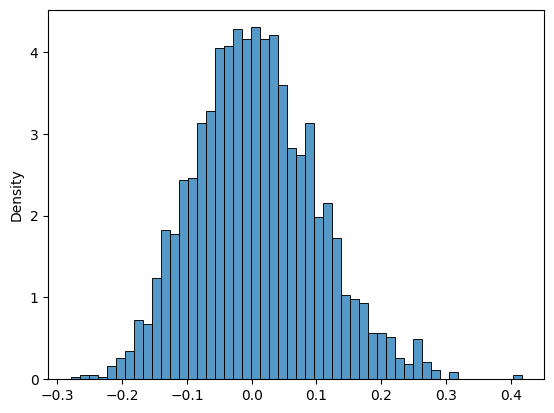

In [59]:
sns.histplot(((408/230)**delta_vec - 1)*(1-TCMB/T230), bins=50, stat='density')
plt.show()

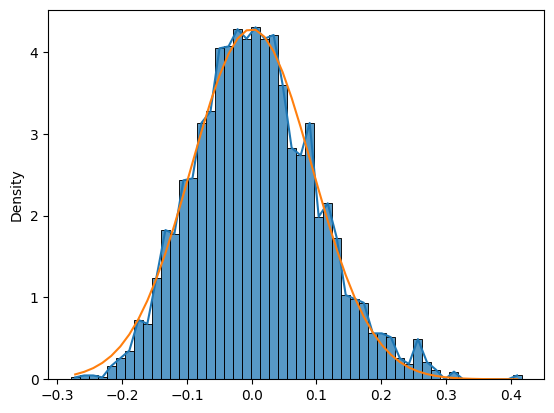

Gauss width = 0.09321686354584098


array([[0.00139612]])

In [60]:
p_vec = ((408/230)**delta_vec - 1)*(1-TCMB/T230)
n, bins = np.histogram(p_vec, bins=50, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)

f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*(x/sig)**2)
res = curve_fit(f, xx, n)
sns.histplot(((408/230)**delta_vec - 1)*(1-TCMB/T230), bins=50, stat='density')
plt.plot(xx, n)
plt.plot(xx, f(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])
np.sqrt(res[1])

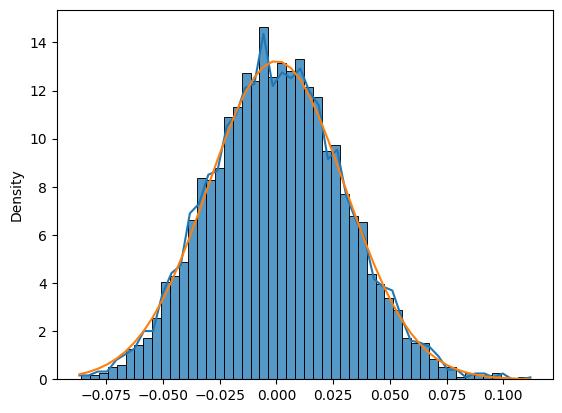

Gauss width = 0.030166512718989614


array([[0.00030031]])

In [57]:
p_vec_simp = ((408/230)**delta_vec - 1)
n, bins = np.histogram(p_vec_simp, bins=50, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)

f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*(x/sig)**2)
res = curve_fit(f, xx, n)
sns.histplot(((408/230)**delta_vec - 1)*(1-TCMB/T230), bins=50, stat='density')
plt.plot(xx, n)
plt.plot(xx, f(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])
np.sqrt(res[1])

In [53]:
SM.basemap_err_to_delta(5)

0.08512072063579337